![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

print(data.head())
# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

   Price  Year  Mileage State       Make      Model
0  34995  2017     9913    FL       Jeep   Wrangler
1  37895  2015    20578    OH  Chevrolet   Tahoe4WD
2  18430  2012    83716    TX        BMW      X5AWD
3  24681  2014    28729    OH   Cadillac  SRXLuxury
4  26998  2013    64032    CO       Jeep   Wrangler


,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [47]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [48]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [67]:
# Celda 1

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k    
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, MSE=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)
print(tree)


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


predicciones=tree_predict(X_test, tree)


{'y_pred': 1, 'y_prob': 0.5778472913408218, 'level': 0, 'split': [1, 51394.909090909096], 'n_samples': 7031, 'gain': 0.23630504821132137, 'sl': {'y_pred': 1, 'y_prob': 0.8375781948168007, 'level': 1, 'split': [0, 2015.0], 'n_samples': 4474, 'gain': 0.03713896892744761, 'sl': {'y_pred': 1, 'y_prob': 0.6404416839199448, 'level': 2, 'split': [0, 2013.0], 'n_samples': 1447, 'gain': 0.043426293133466354, 'sl': {'y_pred': 0, 'y_prob': 0.2780487804878049, 'level': 3, 'split': [0, 2012.0], 'n_samples': 203, 'gain': 0.05394731382546758, 'sl': {'y_pred': 0, 'y_prob': 0.09195402298850575, 'level': 4, 'split': [1, 35652.36363636363], 'n_samples': 85, 'gain': 0.01352946029496721, 'sl': {'y_pred': 0, 'y_prob': 0.24, 'level': 5, 'split': -1, 'n_samples': 23, 'gain': 0.08132745221592097}, 'sr': {'y_pred': 0, 'y_prob': 0.046875, 'level': 5, 'split': -1, 'n_samples': 62, 'gain': 0.0038712154997273124}}, 'sr': {'y_pred': 0, 'y_prob': 0.4166666666666667, 'level': 4, 'split': [1, 24887.363636363636], 'n_sa

In [72]:

predicciones1=predicciones.tolist()
y_test1=y_test.tolist()
tp=0
tn=0
fp=0
fn=0
i=0
listi=[]
while i < len(predicciones1):
    if predicciones1[i]==1:
        if y_test1[i]==1:
            tp=tp+1
        else:
            fp=fp+1
    else:
        if y_test1[i]==0:
            tn=tn+1
        else:
            fn=fn+1
    i=i+1
accuracy_tree=(tp+tn)/(tp+tn+fp+fn)
print('verdaderos positivos: '+str(tp))
print('verdaderos negativos: '+str(tn))
print('falsos positivos: '+str(fp))
print('falsos negativos: '+str(fn))
print(accuracy_tree)





verdaderos positivos: 1929
verdaderos negativos: 1147
falsos positivos: 291
falsos negativos: 97
0.8879907621247113


------------- Árbol con librería y CV--------------


Text(0, 0.5, 'Accuracy')

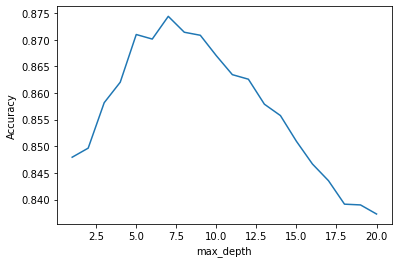

In [73]:
print('------------- Árbol con librería y CV--------------')

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline
import matplotlib.pyplot as plt


# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')



In [74]:
print('-----------un solo árbol-------------')
from sklearn import tree
clf1=DecisionTreeClassifier(max_depth=depth, random_state=1)
clf1=clf.fit(X_train, y_train)
prediccionlibrary=clf1.predict(X_test)
print (prediccionlibrary)


predicciones2=prediccionlibrary.tolist()
y_test2=y_test.tolist()
tp=0
tn=0
fp=0
fn=0
i=0
listi=[]
while i < len(predicciones2):
    if predicciones2[i]==1:
        if y_test2[i]==1:
            tp=tp+1
        else:
            fp=fp+1
    else:
        if y_test2[i]==0:
            tn=tn+1
        else:
            fn=fn+1
    i=i+1
accuracy_tree=(tp+tn)/(tp+tn+fp+fn)
print('verdaderos positivos: '+str(tp))
print('verdaderos negativos: '+str(tn))
print('falsos positivos: '+str(fp))
print('falsos negativos: '+str(fn))
print(accuracy_tree)





-----------un solo árbol-------------
[0 0 1 ... 1 0 0]
verdaderos positivos: 1792
verdaderos negativos: 1152
falsos positivos: 286
falsos negativos: 234
0.8498845265588915


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [44]:
# Celda 2


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 3


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 4


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [5]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
